In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import cv2
import albumentations as A

# Load dataset

In [2]:
path = "D:/LFPW"

In [3]:
train_image = np.load(os.path.join(path,"train_image.npy"), allow_pickle=True)
train_annotation = np.load(os.path.join(path,"train_annotation.npy"), allow_pickle=True)
test_image = np.load(os.path.join(path,"test_image.npy"), allow_pickle=True)
test_annotation = np.load(os.path.join(path,"test_annotation.npy"), allow_pickle=True)

# Preprocess image

In [4]:
def make_dataset_float(X, size):
    img_data = []
    for image in X:
        image = cv2.resize(image, (size, size), interpolation=cv2.INTER_NEAREST)
        image = image.astype('float32')
        image /= 255 
        img_data.append(image)
    return np.array(img_data)

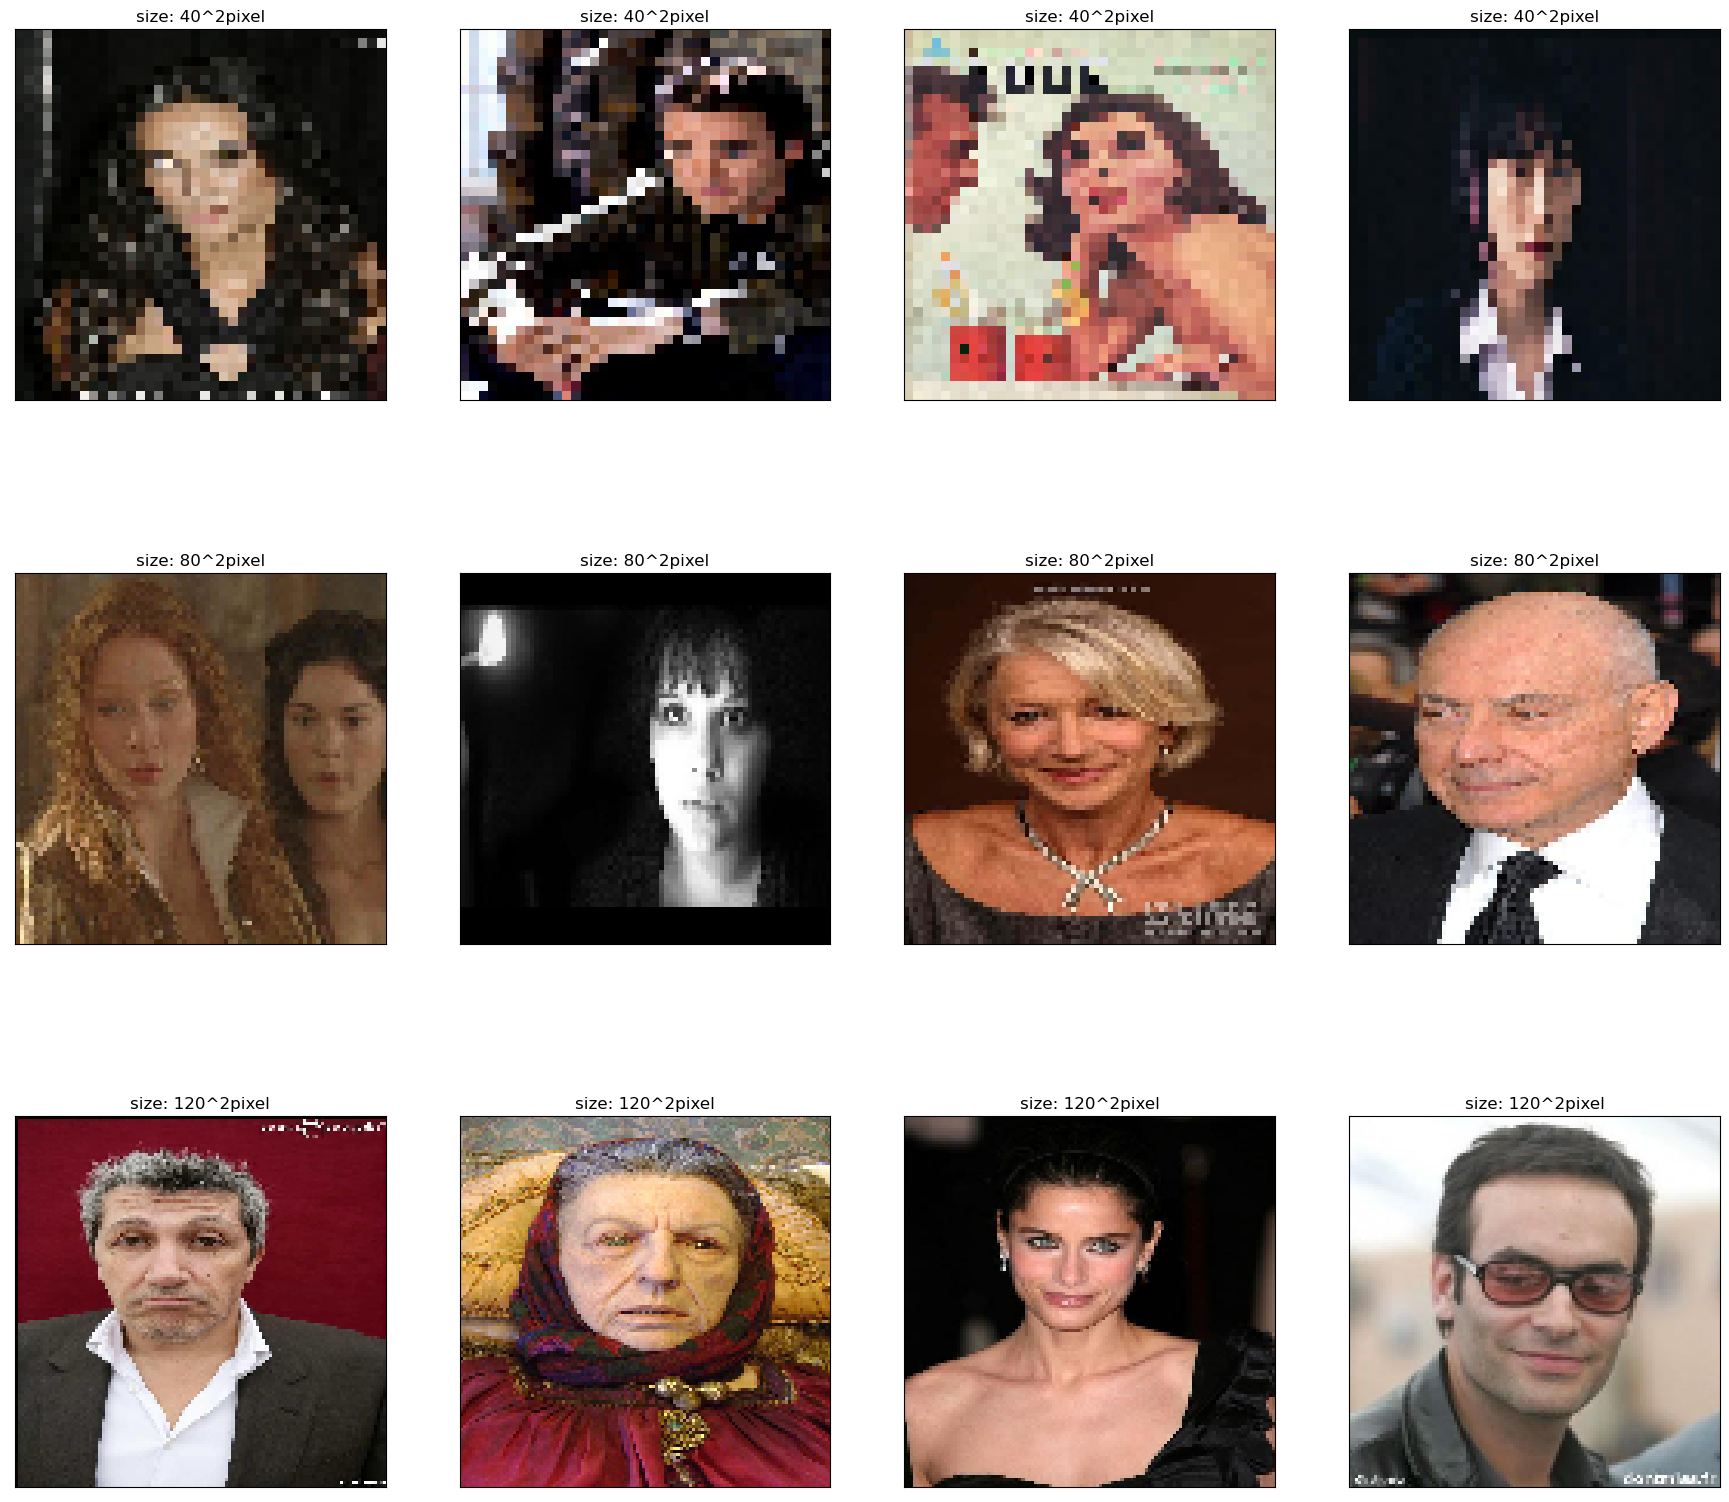

In [5]:
fig, ax = plt.subplots(3, 4, figsize=(22, 20))
for i in range(12):
    j = i//4
    k = i%4
    dataset = make_dataset_float(test_image, (j+1)*40)
    index = np.random.randint(len(dataset))
    ax[j][k].imshow(dataset[index])
    ax[j][k].set_title("size: {}^2pixel".format((j+1)*40))
    ax[j][k].xaxis.set_ticks([])
    ax[j][k].yaxis.set_ticks([])    

# Make dataset for model

In [6]:
train_keypoint=[]
for i in train_annotation:
    index=0
    for j in range(0, len(train_annotation[0]), 3):
        index+=1
        if index > 36 and index < 49:
            train_keypoint.append([i[j], i[j+1]])

In [7]:
test_keypoint=[]
for i in test_annotation:
    index=0
    for j in range(0, len(test_annotation[0]), 3):
        index+=1
        if index > 36 and index < 49:
            test_keypoint.append([i[j], i[j+1]])

In [8]:
train_keypoint = np.reshape(train_keypoint, (train_image.shape[0], 12, 2))
test_keypoint = np.reshape(test_keypoint, (test_image.shape[0], 12, 2))

In [9]:
transform_crop = A.Compose([
    A.Resize(200, 200, interpolation=cv2.INTER_AREA),
    A.RandomCrop(160, 160),
    A.HorizontalFlip(p=1), 
    A.Cutout(num_holes=7, max_h_size=50, max_w_size=50,p=0.8),
    A.RandomBrightnessContrast(brightness_limit=(-0.7, 0.7), contrast_limit=[-0.7, 0.7])
], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False))

transform_resize = A.Compose([
    A.Resize(160, 160, interpolation=cv2.INTER_AREA),
], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False))

C:\Users\hjhhi\anaconda3\envs\python3.9.0\lib\site-packages\albumentations\augmentations\transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [10]:
X_train = []
y_train = []
for index in range(5):
    for i in range(len(train_image)):
        transformed = transform_crop(image = train_image[i], keypoints = train_keypoint[i])
        X_train.append(transformed["image"])
        y_train.append(transformed["keypoints"])    

In [11]:
X_test = []
y_test = []
for i in range(len(test_image)):
    transformed = transform_resize(image = test_image[i], keypoints = test_keypoint[i])
    X_test.append(transformed["image"])
    y_test.append(transformed["keypoints"])  

Example of augmented images

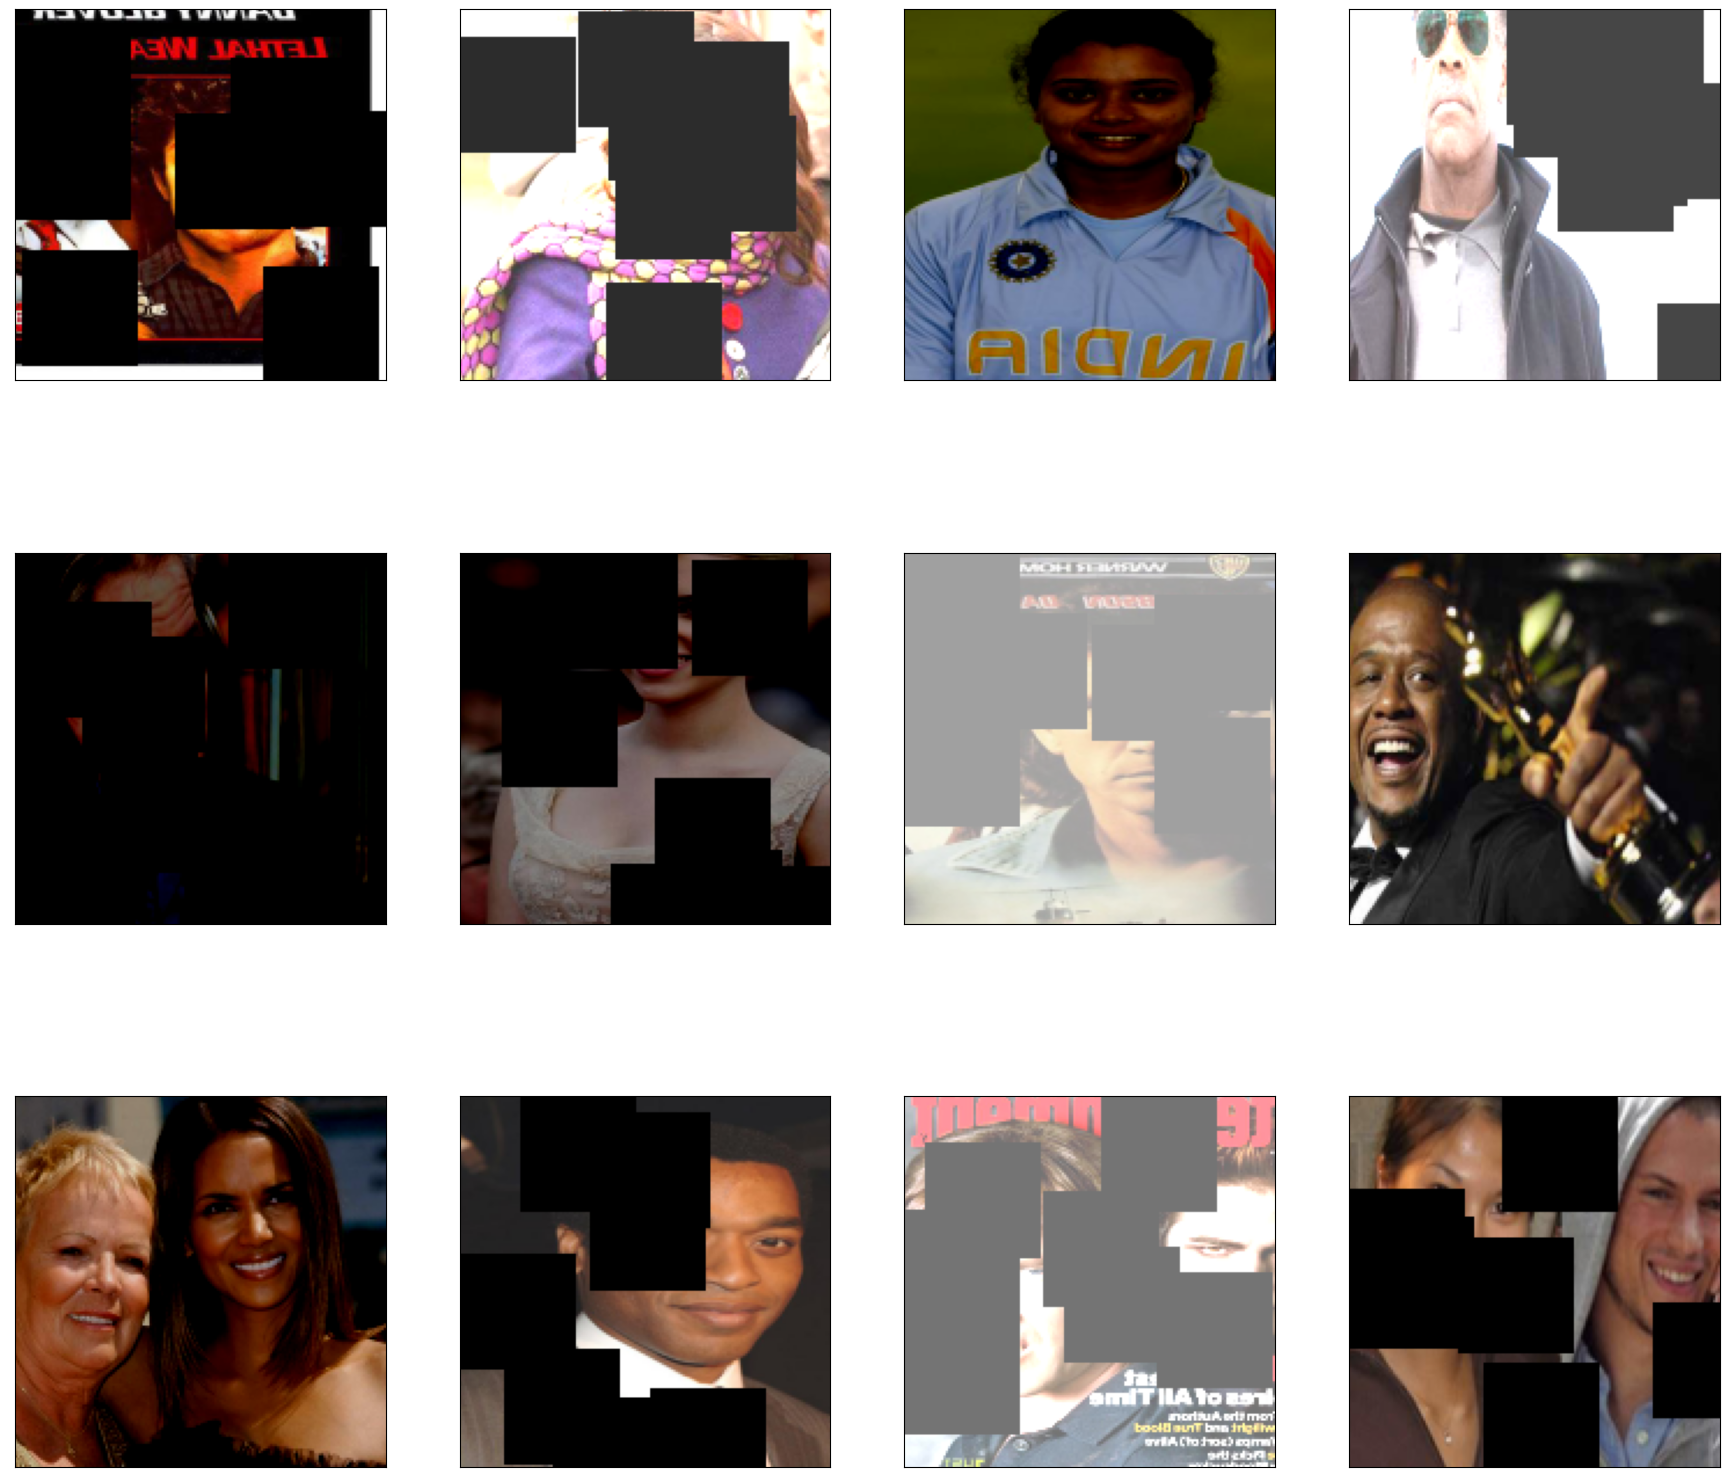

In [12]:
fig, ax = plt.subplots(3, 4, figsize=(22, 20))
for i in range(12):
    j = i//4
    k = i%4
    index = np.random.randint(len(dataset))
    ax[j][k].imshow(X_train[index])
    ax[j][k].xaxis.set_ticks([])
    ax[j][k].yaxis.set_ticks([])

In [16]:
X_train = np.array(X_train) 
y_train = np.reshape(y_train, (X_train.shape[0], 24))
X_test = np.array(X_test) 
y_test = np.reshape(y_test, (X_test.shape[0], 24))

# Visualize model's prediction

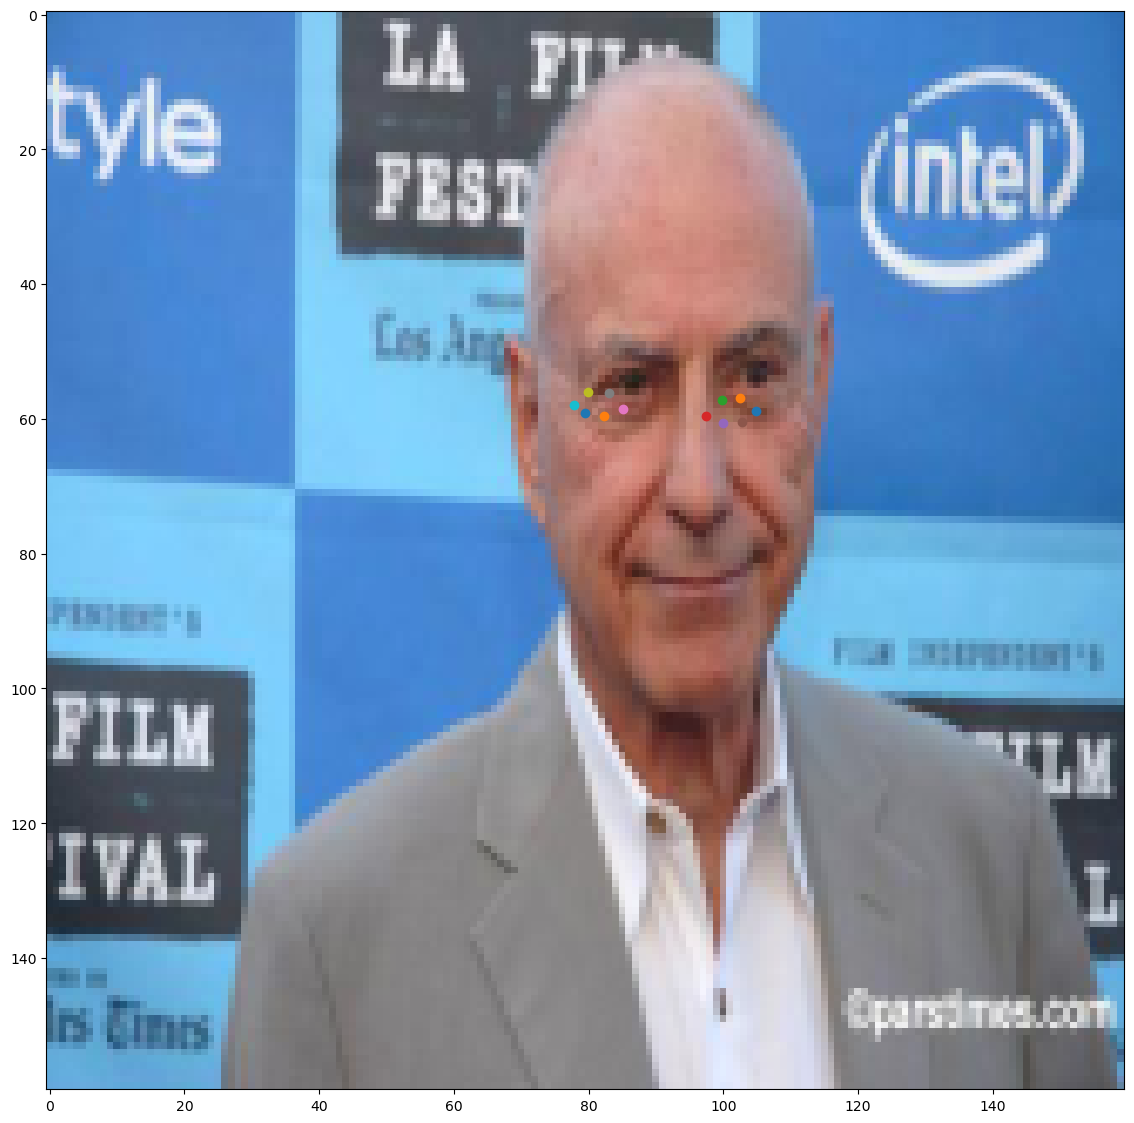

In [44]:
index = 13
fig, ax = plt.subplots(figsize=(14, 14))
pred = model.predict(np.array([X_test[index]]))[0]
ax.imshow(X_test[index])
for i in range(0, 24, 2):
    ax.scatter(pred[i], pred[i+1])

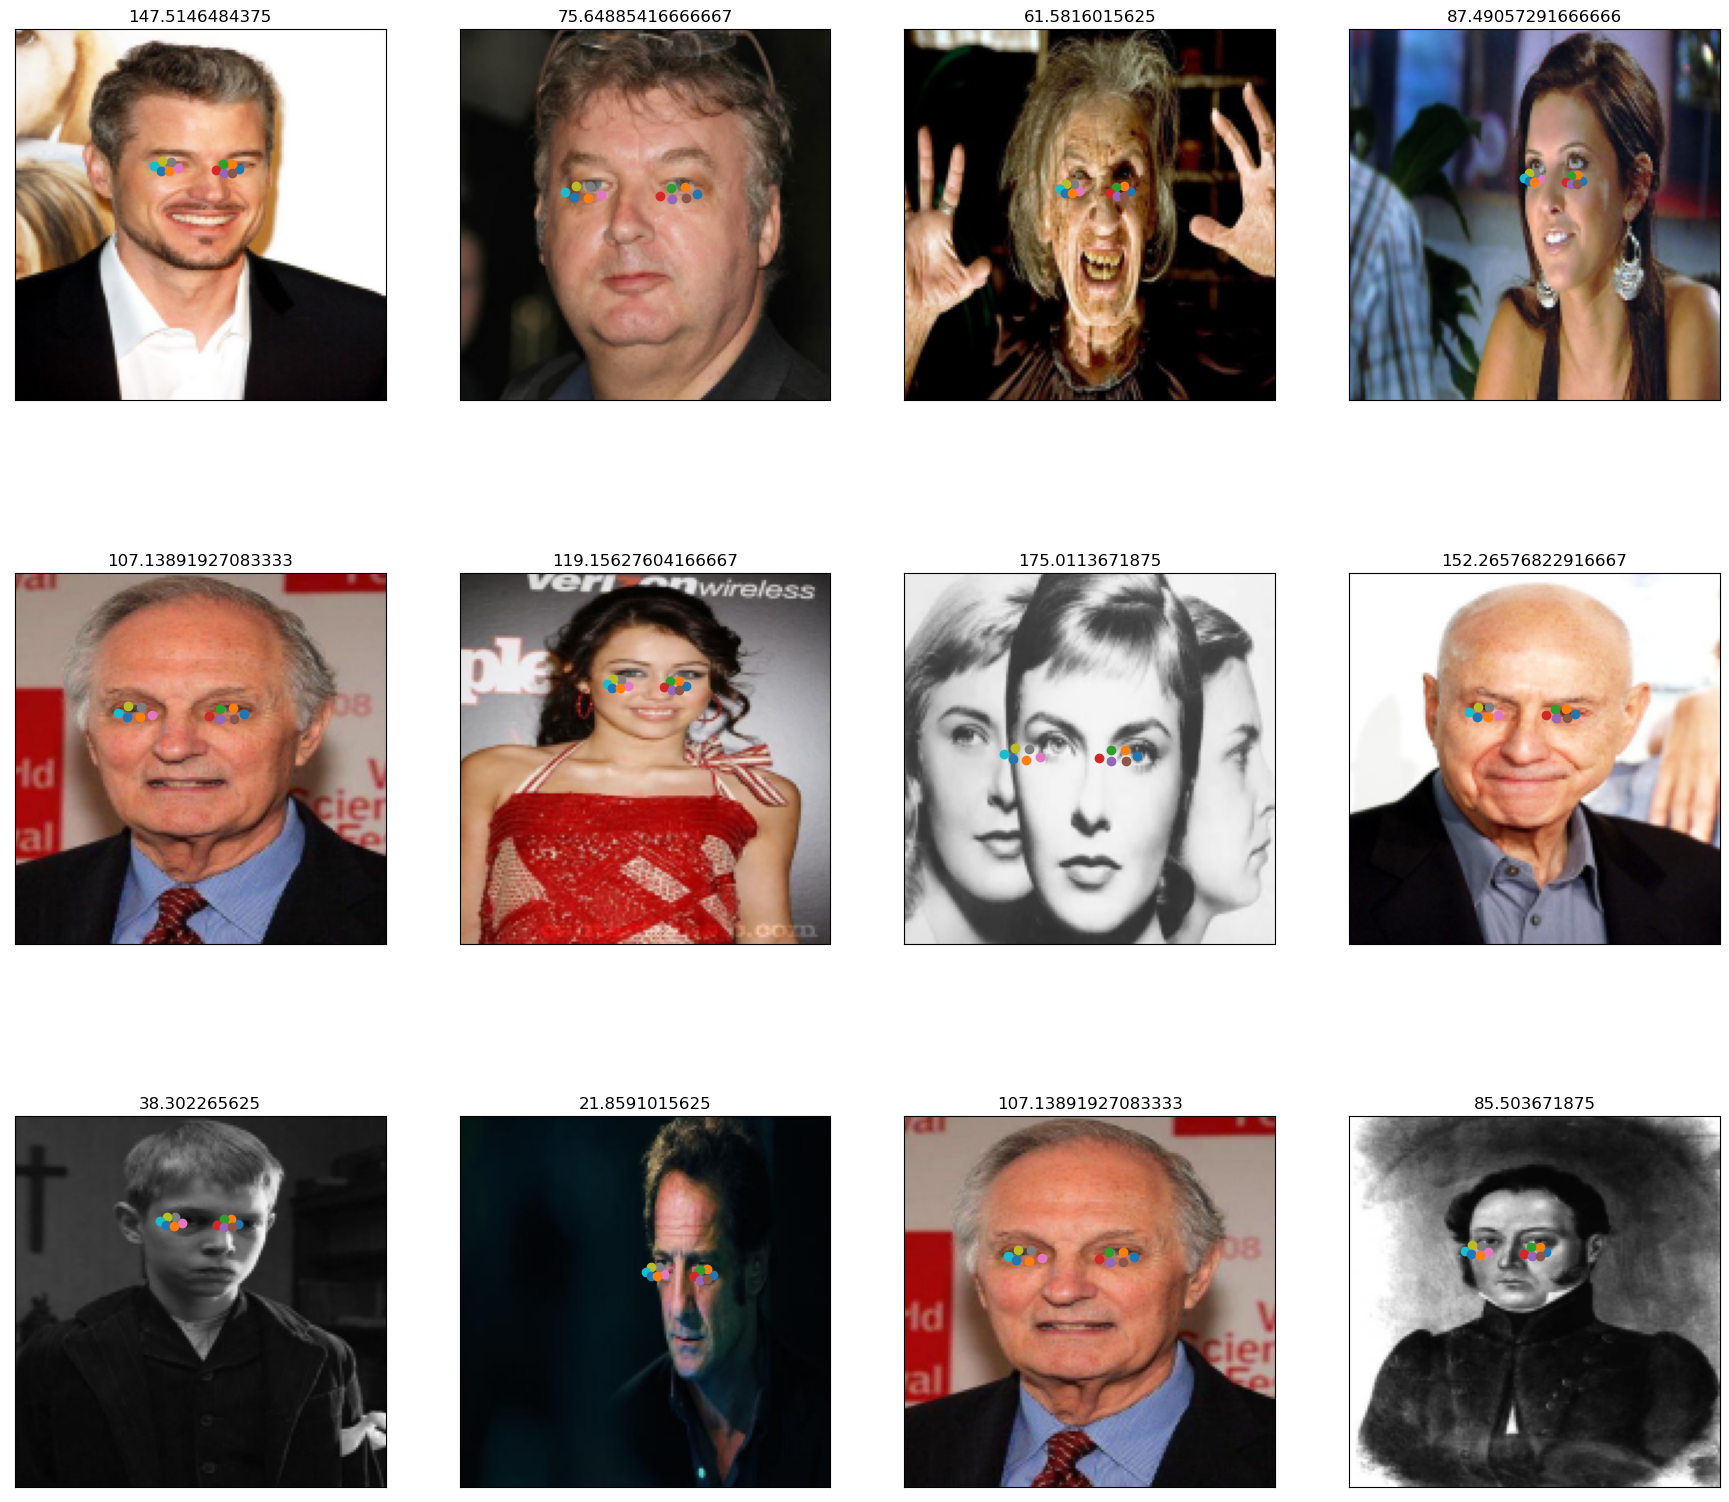

In [49]:
fig, ax = plt.subplots(3, 4, figsize=(22, 20))
for i in range(12):
    j = i//4
    k = i%4
    index = np.random.randint(len(dataset))
    pred = model.predict(np.array([X_test[index]]))[0]
    ax[j][k].imshow(X_test[index])
    ax[j][k].set_title(X_test[index].mean())
    ax[j][k].xaxis.set_ticks([])
    ax[j][k].yaxis.set_ticks([])   
    for i in range(0, 24, 2):
        ax[j][k].scatter(pred[i], pred[i+1])

# Using trasnfer learning

In [17]:
transfer_model = keras.applications.EfficientNetB0(weights="imagenet", include_top=False, input_shape=(X_train.shape[1], X_train.shape[2], 3),
                                                  )

In [18]:
x = transfer_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
predictions = keras.layers.Dense(24, activation="linear", kernel_initializer="he_normal")(x)

In [19]:
model = keras.Model(inputs=transfer_model.input, outputs=predictions)

In [20]:
for layer in transfer_model.layers:
    layer.trainable = False

In [21]:
model.compile(loss=keras.losses.mse, optimizer="adam", metrics="mse")
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=5)

Epoch 1/5
123/123 [==============================] - 17s 74ms/step - loss: 4370.3936 - mse: 4370.3936 - val_loss: 4067.2876 - val_mse: 4067.2876
Epoch 2/5
123/123 [==============================] - 8s 62ms/step - loss: 2934.3340 - mse: 2934.3340 - val_loss: 3101.4512 - val_mse: 3101.451245.7
Epoch 3/5
123/123 [==============================] - 8s 62ms/step - loss: 2079.9395 - mse: 2079.9395 - val_loss: 2410.4126 - val_mse: 2410.4126
Epoch 4/5
123/123 [==============================] - 8s 62ms/step - loss: 1589.0159 - mse: 1589.0159 - val_loss: 1939.6814 - val_mse: 1939.6814
Epoch 5/5
123/123 [==============================] - 8s 62ms/step - loss: 1309.7482 - mse: 1309.7482 - val_loss: 1617.0115 - val_mse: 1617.0115


In [22]:
for layer in model.layers:
   layer.trainable = True

In [127]:
model_temp = keras.models.clone_model(model)

In [23]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_lr=0.0001, verbose=1, mode="min")
ES = keras.callbacks.EarlyStopping(monitor = "val_loss", patience=5, verbose=1, mode="min")

In [24]:
model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics="mse")
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=100, callbacks=[reduce_lr, ES])

Epoch 1/100
123/123 [==============================] - 40s 258ms/step - loss: 774.6448 - mse: 774.6448 - val_loss: 1125.2985 - val_mse: 1125.2985
Epoch 2/100
123/123 [==============================] - 30s 246ms/step - loss: 338.9343 - mse: 338.9343 - val_loss: 700.4763 - val_mse: 700.4763
Epoch 3/100
123/123 [==============================] - 30s 246ms/step - loss: 210.5075 - mse: 210.5075 - val_loss: 629.6710 - val_mse: 629.6710
Epoch 4/100
123/123 [==============================] - 30s 247ms/step - loss: 139.9554 - mse: 139.9554 - val_loss: 601.9373 - val_mse: 601.9373
Epoch 5/100
123/123 [==============================] - 30s 247ms/step - loss: 132.1526 - mse: 132.1526 - val_loss: 626.5864 - val_mse: 626.5864
Epoch 6/100
123/123 [==============================] - 30s 248ms/step - loss: 98.4421 - mse: 98.4421 - val_loss: 609.9350 - val_mse: 609.9350
Epoch 7/100
123/123 [==============================] - 30s 247ms/step - loss: 86.1506 - mse: 86.1506 - val_loss: 688.0876 - val_mse: 688

In [46]:
model.save('./efficientnet_160.h5')